In [165]:
from numpy.random import randn
import numpy as np
from itertools import count
from collections import namedtuple
from torch.utils.tensorboard import SummaryWriter
import os
import seaborn as sns
#import args
from scipy import stats
import pandas as pd
from datetime import datetime, timedelta
import random
from collections import namedtuple
import torch as pt
import statistics
import csv

#from replay_memory import Memory, Transition
#from ounoise import OrnsteinUhlenbeckActionNoise as noise
#from market_env import trade_env
#import market_env

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import random
from functools import reduce
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=DeprecationWarning)


In [166]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/TESI/Codice")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/TESI/Codice'

In [167]:
!pip install stockstats
from preprocessors_3 import FeatureEngineer#,moving_average

In [168]:
path = '/content/drive/MyDrive/TESI'
writer = SummaryWriter(path + '/tensor')


for file in os.listdir(path + '/tensor'):
    file = os.path.join(path + '/tensor',file)
    os.remove(file)


In [169]:
capacity=1000000
class Replay_buffer():
    '''
    Expects tuples of (state, next_state, action, reward, done)
    '''
    def __init__(self, max_size=capacity):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def push(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        state: np.array
            batch of state or observations
        action: np.array
            batch of actions executed given a state
        reward: np.array
            rewards received as results of executing action
        next_state: np.array
            next state next state or observations seen after executing action
        done: np.array
            done[i] = 1 if executing ation[i] resulted in
            the end of an episode and 0 otherwise.
        """
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        state, next_state, action, reward, done = [], [], [], [], []

        for i in ind:
            st, n_st, act, rew, dn = self.storage[i]
            state.append(np.array(st, copy=False))
            next_state.append(np.array(n_st, copy=False))
            action.append(np.array(act, copy=False))
            reward.append(np.array(rew, copy=False))
            done.append(np.array(dn, copy=False))

        return np.array(state), np.array(next_state), np.array(action), np.array(reward).reshape(-1, 1), np.array(done).reshape(-1, 1)



#ALTRA OPZIONE DI REPLAY BUFFER
Transition = namedtuple('Transition', ('state','action', 'mask', 'utility', 'next_state'))


class Memory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None) #None values are placeholders that allow the replay memory to be initialized without having to worry about the actual contents of the memory at the start.
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)




# **Actor-Critic Neural Network**

The code defines two neural network models, an Actor and a Critic.

**Input to Actor model**: Environment state
**Output of the Actor model**: an action that has a continuous value.

**Input to Critic model**: Environment state and action
**Output of the Critic model**: A Q-value that is the expected total reward for the current state-action pair.


In [170]:
class Actor(nn.Module):
    def __init__(self, n_states, action_dim, hidden1): #n_states --> should be the number of inputs passed --> num_inputs = ((action_space - 1) * state_space) = 60
        super(Actor, self).__init__()
        self.affine1 = nn.Linear(n_states, hidden1)
        self.ln1 = nn.LayerNorm(hidden1)

        self.affine2 = nn.Linear(hidden1, hidden1)
        self.ln2 = nn.LayerNorm(hidden1)

        self.value = nn.Linear(hidden1, action_dim)

    def forward(self, x):
        x = self.affine1(x)
        x = self.ln1(x)
        x = F.relu(x)

        x = self.affine2(x)
        x = self.ln2(x)
        actions = F.softmax(self.value(x), dim=-1)

        return actions


'''
class Critic(nn.Module):
    def __init__(self, n_states, action_dim, hidden2):
        super(Critic, self).__init__()
        print(f'N_states citric: {n_states}, action_dim citric: {action_dim}')
        self.affine1 = nn.Linear(n_states + action_dim, hidden2)
        self.ln1 = nn.LayerNorm(hidden2)

        self.affine2 = nn.Linear(hidden2, hidden2)
        self.ln2 = nn.LayerNorm(hidden2)

        self.value = nn.Linear(hidden2, 1)

    def forward(self, x, actions):
        x = self.affine1(x)
        x = self.ln1(x)
        x = F.relu(x)

        #x = torch.cat((x, actions), 1)
        x = self.affine2(x)
        x = self.ln2(x)
        q_value = self.value(F.relu(x))

        return q_value

'''

#second citric option

class Critic(nn.Module):
    def __init__(self, n_states, action_dim, hidden2):
        super(Critic, self).__init__()
        self.affine1 = nn.Linear(n_states, hidden2)
        self.ln1 = nn.LayerNorm(hidden2)

        self.affine2 = nn.Linear(action_dim + hidden2, hidden2)
        self.ln2 = nn.LayerNorm(hidden2)

        self.value = nn.Linear(hidden2, 1)

    def forward(self, x, actions):
        x = self.affine1(x)
        x = self.ln1(x)
        x = F.relu(x)

        x = torch.cat((x, actions), 1)
        x = self.affine2(x)
        x = self.ln2(x)
        q_value = self.value(F.relu(x))

        return q_value

# Envirionment

In [171]:
folder_path = '/content/drive/MyDrive/TESI/Codice'

In [172]:
def get_return(df, var):
    df['G1'] = df[var].pct_change(1)
    df['N1'] = np.log(df[var].pct_change(1)+1) #dayly log return

    df['G5'] = df[var].pct_change(5)
    df['N5'] = np.log(df[var].pct_change(5)+1)# 5 day log return

    df['G1_mon'] = df[var].pct_change(25)
    df['N1_mon'] = np.log(df[var].pct_change(25)+1)

    df['G6_mon'] = df[var].pct_change(125)
    df['N6_mon'] = np.log(df[var].pct_change(125)+1)

    df['G1_yr'] = df[var].pct_change(250)
    #df['N1_yr'] = np.log(df[var].pct_change(250)+1)

    df['G2_yr'] = df[var].pct_change(500)
    #df['N2_yr'] = np.log(df[var].pct_change(500)+1)

#     df['MA2'] = df[var].rolling(2, min_periods=2).mean()
    #df['MA4'] = df[var].rolling(4, min_periods=4).mean()
    return df

def get_return_std(df, y):
    df['R1_std'] = df[y].rolling(125, min_periods=125).std()
    df['R2_std'] = df[y].rolling(250, min_periods=250).std()
    return df

def get_state(df):
    df = get_return(df, 'adj close')
    df = get_return_std(df, 'N1')
    # keep states needed
    df = df[['Date', 'adj close', 'volume'] + fe.tech_indicator_list  + list(df.filter(regex='^N|^R|^MA'))]
    df = df.rename(columns={'adj close': 'close'})
    return df



def get_training_set(dic):
    train = {}
    for key, value in dic.items():
        train[key] = value.loc[(value.Date >= start_date) & (value.Date < end_date)].reset_index(drop=True)
        train[key] = get_state(train[key])
        #train[key] = train[key].iloc[500:].reset_index(drop=True)
        train[key]['weekday'] = pd.to_datetime(train[key].Date).dt.dayofweek
        train[key] = train[key].dropna().reset_index(drop=True)
    return train

# save 500 days to calculate 2-year return
def get_test_set(dic):
    test = {}
    for key, value in dic.items():
        test[key] = value.iloc[int(value.index[value.Date==end_date].values - 500):].reset_index(drop=True)
        test[key] = get_state(test[key])
        test[key] = test[key].iloc[500:].reset_index(drop=True)
        test[key]['weekday'] = pd.to_datetime(test[key].Date).dt.dayofweek
    return test

In [173]:

#for key, value in stock_d.items():
  #print (key)
  #print(stock_d[key])

In [174]:
def get_holidays(df):
    df['Date'] = pd.to_datetime(df['Date'])
    date = df['Date'].min()
    end_date = df['Date'].max()
    holidays = []
    while date <= end_date:
        if date.weekday() <= 5:
          if date not in list(df.Date):
            holidays.append(date.strftime("%Y-%m-%d"))
        date += timedelta(days=1)
    df['Date'] = df['Date'].astype(str)
    return holidays

In [175]:
def baseline_portfolio(dic, start_date, worth, end_date):
  stock_quantity = {}
  stock_number = len(dic)-1
  for key, df in dic.items():
    if key != '^GSPC':
      stock_amount = worth / stock_number
      sotck_value = df[df['Date'] == start_date]['close'].item()

      stock_quantity[key] = (stock_amount/sotck_value)

  portfolio = pd.DataFrame(columns=['Date', 'Value'])
  portfolio = portfolio.append({'Date': start_date, 'Value': worth}, ignore_index=True)



  portfolio_value = 0
  date = start_date

  while date != end_date:

    for key, df in dic.items():
      if key != '^GSPC':
        portfolio_value += stock_quantity[key] * df[df['Date'] == date]['close'].item()
    portfolio = portfolio.append({'Date': date, 'Value': portfolio_value}, ignore_index=True)
    portfolio_value = 0
    date = add_one_trade_day(date)

  return portfolio



In [176]:
%%capture
#load stocks

data_folder = '/content/drive/MyDrive/TESI/00_Raw_Data'
os.chdir(data_folder)
stock = [x.replace('.csv', '') for x in os.listdir(data_folder)]
stock = [x for x in stock if x!='TSLA' and x!='AMZN' and x!='KO' and x!='MSFT'] #used stocks --> ['AAPL, XOM, UNH, PG, JPM]
# stock = ['SPX', 'BA', 'MS']
tables = [pd.read_csv(x + ".csv", skiprows= range(1, 1901) ) for x in stock ]
stock_d = dict(zip(stock, tables)) # line_plot(stock_d['SPX'], 'close', 'SPX')

#FeatureEngineer on loaded data
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

for key, df in stock_d.items():
    stock_d[key]= fe.preprocess_data(stock_d[key])
    stock_d[key].rename(columns={'date': 'Date'}, inplace=True)



# env para
start_date = max([value.Date.min() for key, value in stock_d.items()])
end_date = '2022-01-05'
worth = 20000
bottom_line = worth * 0.9 #episode stop if we loose more than this amount
cycle = 7 #is the max steps of each episode
memory = Memory(100000)

# get train and test
train = get_training_set(stock_d)
test = get_test_set(stock_d)
holidays = get_holidays(train['^GSPC']) + get_holidays(test['^GSPC'])
#train = get_holiday_dummy(train)
#test = get_holiday_dummy(test)
train['^GSPC']['close'] = train['^GSPC']['close']/10 # I think is a sort of re-scaling
test['^GSPC']['close'] = test['^GSPC']['close']/10 # I think is a sort of re-scaling


def concat(x,y): return pd.concat([x,y], axis=0).reset_index(drop=True)

def get_info(env, date): #return information for each stock for a specific day
    info_matrix = []
    info_SPX = []
    for key, df in env.items():
        if key == '^GSPC':
          df['stock'] = key
          a = df.loc[df.Date == date]
          info_SPX += [a]
        else:
          df['stock'] = key
          b = df.loc[df.Date == date] #a that only contains rows where the date column in df matches the specified date value
          info_matrix += [b]
    return reduce((lambda x, y: concat(x,y)), info_matrix),reduce((lambda x, y: concat(x,y)), info_SPX)# combine multiple DataFrames in a list called info_matrix into a single DataFrame.

def fraction_power(x, n):
    if 0<=x: return x**(1./n)
    return -(-x)**(1./n)


def add_days(date, days):
    new_datetime = datetime.strptime(date, "%Y-%m-%d") + timedelta(days)
    new_date = new_datetime.strftime("%Y-%m-%d")
    return new_date



def add_one_trade_day(date):
    date = add_days(date, 1)
    while (datetime.strptime(date, "%Y-%m-%d").weekday()>=5) or (date in holidays):
        date = add_days(date, 1)
    return date




# this env does not have interest rate or mutual fund, and has no transaction cost
class trade_env():
    def __init__(self, env, worth, cycle, rho):
        self.env = env
        self.cycle = cycle
        self.rho = rho
        self.action_space = len(env.keys()) # Is the number of stocks  + 1 for holding cahs (the +1 is given by the '^GSPC' values in the env )
        self.state_space = len(env['^GSPC'].columns) - 1 # minus 2 to not consider column "stock" and "date" !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        self.end_date = env['^GSPC'].Date.max()
        self.reset(worth)

    def step(self, action):

         # normalize to sum of 1
        action = (np.array(action) - np.array(action).min()) / (np.array(action) - np.array(action).min()).sum()

        #print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')
        #print(f'action: {action}, action sum: {np.sum(action)}')
        #print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')

        # today
        last_worth = self.worth
        last_baseline_woth = self.baseline_worth
        stock_info, SPX_info = get_info(self.env, self.date)


        self.prices = np.append([1], stock_info.close.to_numpy())  # 1 is the opportunity cost of holding cash (This expression creates a new NumPy array and appends the value 1 to the beginning of the array.)

        self.share = self.worth * action // self.prices #tell how many share of each stock the agent is buying
        changes = (self.worth * action % self.prices)[1: self.action_space]
        self.share[0] = self.share[0] + np.sum(changes) # changes go to cash, i.e., share[0]

        #BASELINE CALCULATION
        if self.baseline_worth == 20000: #questo perchè voglio che solo al primo episodio si scelga il numero di stock da comprare di ogni azienda, e poi questo numero deve rimanere uguale
          self.base_share = self.baseline_worth * np.array(([1/(self.action_space - 1)] *(self.action_space - 1)))/ self.prices[1:] #I'm considering the possibilities of buy portions of the stock
        #print(f'baseline share: {self.base_share}, base line action: {np.array(([1/(self.action_space - 1)] *(self.action_space - 1))) }')




        # next day

        self.date = add_one_trade_day(self.date)
        new_stock_info, new_SPX_info = get_info(self.env, self.date)


        new_prices = np.append([1], new_stock_info.close.to_numpy())
        self.worth  = np.sum(self.share * new_prices)
        self.baseline_worth = np.sum(self.base_share * new_prices[1:])
        baseline_reward = self.baseline_worth - last_baseline_woth
        print(f'baselibe reward: {baseline_reward}')
        # reality
        state = np.array(new_stock_info.drop(['Date', 'stock'],axis=1))
        reward = self.worth - last_worth
        print(f'Reward: {reward}')


        utility = fraction_power(reward, self.rho)
        gone = datetime.strptime(self.date, "%Y-%m-%d") - datetime.strptime(self.initial_date, "%Y-%m-%d") #how many days passed since the beginning

        if (self.worth < bottom_line) or (gone.days > self.cycle) or (self.date == self.end_date): #if one of this condition is meet, stop it, and take another decision
            done = True                                                                            #es. if cycle = 7 means that the agent will make trading decisions every 7 days.
        else:
            done = False

        return state, reward, baseline_reward, utility, done, self.worth, self.baseline_worth

    def reset(self, worth):
        self.worth = worth
        self.SPX_worth = worth
        self.baseline_worth = worth
        self.date = random.choice(self.env['^GSPC'].Date) #the agent has a random trading starting date
        self.initial_date = self.date
        initial_info,SPX_initial_info = get_info(self.env, self.initial_date)
        initial_state = np.array(initial_info.drop(['Date', 'stock'],axis=1))
        initial_SPX = np.array(SPX_initial_info.drop(['Date', 'stock'],axis=1))
        return initial_state, initial_SPX



# DDPG

In [177]:
#Set Hyperparameters
# Hyperparameters adapted for performance from
#https://ai.stackexchange.com/questions/22945/ddpg-doesnt-converge-for-mountaincarcontinuous-v0-gym-environment
capacity=1000000
batch_size=64
update_iteration=200
tau=0.01 # tau for soft updating
gamma=0.999 # discount factor
directory = './'
hidden1=64 # hidden layer for actor
hidden2=64 #hiiden laye for critic

class DDPG(object):
    def __init__(self, state_dim, action_dim):
        """
        Initializes the DDPG agent.
        Takes three arguments:
               state_dim which is the dimensionality of the state space,
               action_dim which is the dimensionality of the action space, and
               max_action which is the maximum value an action can take.

        Creates a replay buffer, an actor-critic  networks and their corresponding target networks.
        It also initializes the optimizer for both actor and critic networks alog with
        counters to track the number of training iterations.
        """
        self.replay_buffer = Replay_buffer()

        num_inputs = ((action_dim - 1) * state_dim) #  flatten info matrix; minus one since cash does not hold info


        self.actor = Actor(num_inputs, action_dim, hidden1).to(device)
        self.actor_target = Actor(num_inputs, action_dim,  hidden1).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())              #The state_dict method returns a dictionary containing the model's parameters and their corresponding values.
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-3)     #By loading the initial weights, the target actor network starts with the same parameters as the main actor network.

        self.critic = Critic(num_inputs, action_dim,  hidden2).to(device)
        self.critic_target = Critic(num_inputs, action_dim,  hidden2).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=2e-2)
        # learning rate



        self.num_critic_update_iteration = 0
        self.num_actor_update_iteration = 0
        self.num_training = 0




    def select_action(self, state):
        """
        takes the current state as input and returns an action to take in that state.
        It uses the actor network to map the state to an action.
        """
        #print(state)
        state = torch.FloatTensor(state.flatten()).to(device)
        return self.actor(state).cpu().detach().numpy().flatten() #.data is deprecated in newer versions of PyTorch, replaced by .detach()


    def update(self):
        """
        updates the actor and critic networks using a batch of samples from the replay buffer.
        For each sample in the batch, it computes the target Q value using the target critic network and the target actor network.
        It then computes the current Q value using the critic network and the action taken by the actor network.

        It computes the critic loss as the mean squared error between the target Q value and the current Q value, and
        updates the critic network using gradient descent.

        It then computes the actor loss as the negative mean Q value using the critic network and the actor network, and
        updates the actor network using gradient ascent.

        Finally, it updates the target networks using
        soft updates, where a small fraction of the actor and critic network weights are transferred to their target counterparts.
        This process is repeated for a fixed number of iterations.
        """
        #saving loss
        policy_loss = []
        value_loss = []

        for it in range(update_iteration):
            # For each Sample in replay buffer batch
             #print(f'siamo nel loop di update iteration numero {it}')
            state, next_state, action, reward, done = self.replay_buffer.sample(batch_size)
            #print(f'action dimension: {action.shape}, vales: {action}')#state is ok
            state = torch.FloatTensor(state.reshape(batch_size, -1))#.to(device)
            state = torch.FloatTensor(state).to(device)

            action = torch.FloatTensor(action).to(device)
            #print(f'action dimension: {action.shape}, values {action}')
            #print(f'1.....next_state type : {type(next_state)}, and shape: {next_state.shape}')
            next_state = torch.FloatTensor(next_state.reshape(batch_size, -1))#.to(device)
            #print(f'2.....next_state type : {type(next_state)}, and shape: {next_state.shape}')
            next_state = torch.FloatTensor(next_state).to(device)


            #print(f'next state dimension: {next_state.shape}, of type {next_state.type}')
            done = torch.FloatTensor(1-done).to(device) #create a tensor of 0(if done = true) and 1(if = false ), done = true means that the episode is done
            reward = torch.FloatTensor(reward).to(device)

            # Compute the target Q value
            target_Q = self.critic_target(next_state, self.actor_target(next_state))


            target_Q = reward + (done * gamma * target_Q).detach() #.detach() is used to detach the tensor from the computation graph, preventing gradients
                                                                # from flowing through target_Q during backpropagation. This is common in Q-learning to treat
            #print(f'target_Q: {target_Q.shape}') # --> [64,1]               # the target Q value as a constant during the optimization of the critic network.

            # Get current Q estimate
            current_Q = self.critic(state, action)


            # Compute critic loss
            critic_loss = F.mse_loss(current_Q, target_Q)
            value_loss.append(critic_loss.item())


            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss as the negative mean Q value using the critic network and the actor network
            actor_loss = -self.critic(state, self.actor(state)).mean()
            policy_loss.append(actor_loss.item())


            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()


            """
            Update the frozen target models using
            soft updates, where
            tau,a small fraction of the actor and critic network weights are transferred to their target counterparts.
            """
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


            self.num_actor_update_iteration += 1
            self.num_critic_update_iteration += 1
        value_loss = statistics.mean(value_loss)
        policy_loss = statistics.mean(policy_loss)
        return(value_loss, policy_loss)


    def save(self):
        """
        Saves the state dictionaries of the actor and critic networks to files
        """
        torch.save(self.actor.state_dict(), directory + 'actor.pth')
        torch.save(self.critic.state_dict(), directory + 'critic.pth')

    def load(self):
        """
        Loads the state dictionaries of the actor and critic networks to files
        """
        self.actor.load_state_dict(torch.load(directory + 'actor.pth'))
        self.critic.load_state_dict(torch.load(directory + 'critic.pth'))


    def save_model(self, path):
        if not os.path.exists(path):
            os.makedirs(path)

        ddpg_actor = os.path.join(path, 'ddpg_actor_weights')
        ddpg_crtic = os.path.join(path, 'ddpg_critic_weights')
        torch.save(self.actor.state_dict(), ddpg_actor)
        torch.save(self.critic.state_dict(), ddpg_crtic)

In [178]:
seed = 543
#memory = Replay_buffer()
noise_scale = 1.5
final_noise_scale = 0.5
worth = 20000
cycle = 7
rho = 3 # coefficient of risk aversion --> high = more risk adverse



In [179]:
import gym

# create the environment
env = trade_env(train, worth, cycle, rho)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define different parameters for training the agent
max_episode=1800
max_time_steps= 500 #cycle = 7  maximum number of training days
ep_r = 0
total_step = 0
score_hist=[]
# for rensering the environmnet
render=True
render_interval=10
# for reproducibility
#env.seed(0)
torch.manual_seed(0)
np.random.seed(0)
#Environment action ans states
state_dim =  env.state_space #number of columns - 1 (to not consider column date) (if does not work try - 2, because maybe there is also the column date )
action_dim = env.action_space #is the number of stock + 1 (hold cash)
max_action = 1
min_Val = torch.tensor(1e-7).float().to(device)

# Exploration Noise#
exploration_noise=0.1
#exploration_noise=0.1 * max_action

In [180]:
# Create a DDPG instance
agent = DDPG(state_dim, action_dim)
print("action_dim: ", action_dim)
print("state_dim: ", state_dim)
num_inputs = ((action_dim - 1) * state_dim)
print("num_inputs: ", num_inputs)
Training_reward = []
Policy_loss = []
Value_loss = []
ep_reward = [] #each element is the total reward of the episode
ep_relative_training_reward = [] #each element is the total realativereward of the episode
updates = 0
total_reward = 0
PolicyLoss_csv_file_= f"/content/drive/MyDrive/TESI/02_parameters/Policy_losses/{cycle}_{max_episode}_{tau}_{gamma}.csv" # Critic_TrainingEpisode_NumEpisodes_Tau_Gamma
ValueLoss_csv_file = f"/content/drive/MyDrive/TESI/02_parameters/Value_losses/{cycle}_{max_episode}_{tau}_{gamma}.csv"

action_dim:  6
state_dim:  16
num_inputs:  80


In [181]:
# Train the agent for max_episodes
for i in range(max_episode):
    print("#========================================================================================#")
    print("episod number: ", i)
    episode_reward = 0
    abs_training_reward = 0
    relative_training_reward = 0
    step =0
    state, SPX_state = env.reset(worth)
    if env.date!=env.end_date: #train_env.date at the beginning is the starting training day
      print(env.date)
      for  t in range(max_time_steps):  #maximum lenght of each episode, for now is setted = 7 by the cycle variable

          #print("day since last decision (i.e. number of training days):", t)
          #print("state:", state)
          action = agent.select_action(state)
          #print("action: ", action, "action sum:", np.sum(action))
          # Add Gaussian noise to actions for exploration
          if i < 1000:
            action = (action + np.random.normal(0, 0.5, size=action_dim)).clip(-max_action, max_action)
          elif 1000 < i and i < 1500:
            action = (action + np.random.normal(0, 0.1, size=action_dim)).clip(-max_action, max_action)
          else:
            action = (action + np.random.normal(0, 0.01, size=action_dim)).clip(-max_action, max_action)

          #print("action: ", action, "action sum:", np.sum(action))
          next_state, reward, baseline_reward, utility, done, portfolio_worth, baseline_worth = env.step(action) # env.step() takes numpy array as inputs
          #print(f'next state: {next_state}')
          relative_training_reward += (reward - baseline_reward)
          episode_reward += reward
          Training_reward += [reward]
          total_reward += reward

         #print(f'reward dimension before pushing: {reward.shape}, reward value:{reward}')
          #print(f'SPX_reward dimension before pushing: {relative_training_reward.shape}, value: {relative_training_reward}')
          #print(f'utility dimension before pushing: {utility.shape}, value {utility}')



          #if render and i >= render_interval : env.render()
          #print(f'next_state dimension before pushing: {next_state.shape}')
          agent.replay_buffer.push((state, next_state, action, relative_training_reward, float(done)))
          state = next_state
          if done: #True when 7 days of training are passed or we lose a certain amount
              break
          step += 1

      #score_hist.append(total_reward)
      ep_reward.append(episode_reward)
      ep_relative_training_reward.append(relative_training_reward)

      total_step += step+1
      print("Episode: \t{}, Episode Reward: \t{} Total Reward: \t{:0.2f}".format( i, episode_reward, total_reward))
      critic_loss, actor_loss = agent.update()
      #print(type(Value_loss))
      #print(type(critic_loss))
      Value_loss.append(critic_loss)
      print(f'Value_loss: {critic_loss}')
      Policy_loss.append(actor_loss)
      print(f'Policy_loss: {actor_loss}')
      #writer.add_scalar('loss/value', critic_loss, updates)
      #writer.add_scalar('loss/policy', actor_loss, updates)
      updates += 1
      #saving the losses
      with open(PolicyLoss_csv_file_, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(Policy_loss)

      with open(ValueLoss_csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(Value_loss)

      if i % 10 == 0:
          os.chdir("/content/drive/MyDrive/TESI/02_parameters") #saving the agent's parameter every 10 episodes
          agent.save()
#env.close()

agent.save_model('/content/drive/MyDrive/TESI/02_parameters')

Streaming output truncated to the last 5000 lines.
Reward: 229.5002732433568
baselibe reward: -178.41805541002032
Reward: -272.44939442868053
baselibe reward: -34.14910291306296
Reward: 89.41167449951172
Episode: 	1515, Episode Reward: 	782.3251469971729 Total Reward: 	124291.41
Value_loss: 59853.2669140625
Policy_loss: 6.924866280555725
#========================================================================================#
episod number:  1516
2020-07-01
baselibe reward: 83.97861857475073
Reward: 3.185724624163413
baselibe reward: 322.84410446278343
Reward: 506.936964847373
baselibe reward: -297.13909349236565
Reward: -67.34240596149175
baselibe reward: 173.95829320238408
Reward: 435.777456394364
baselibe reward: -342.75937177286323
Reward: 69.14203659306077
Episode: 	1516, Episode Reward: 	947.6997764974694 Total Reward: 	125239.11
Value_loss: 58083.92596679687
Policy_loss: 18.36432006239891
#========================================================================================#

#Training evaluation


In [182]:
def moving_average(data, window_size):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

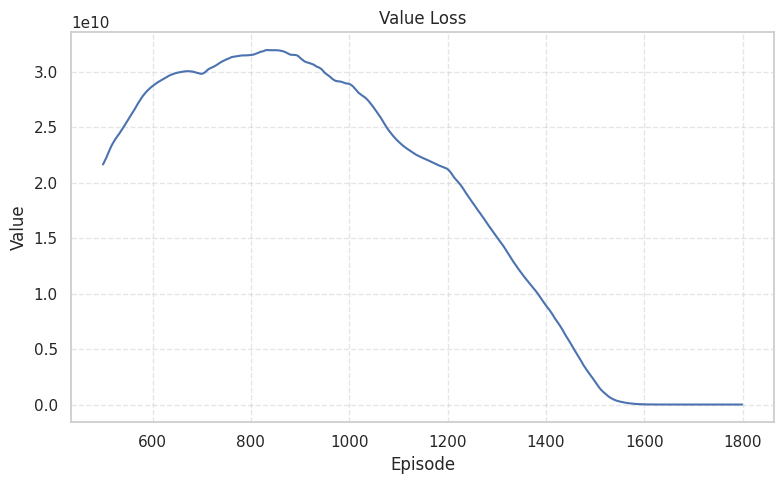

In [183]:
#Value_loss = [int(tensor.item()) for tensor in Value_loss]

window_size = 500

moving_avg = moving_average(Value_loss, window_size)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(window_size - 1, len(Value_loss)), moving_avg, label='Value Loss')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Value Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




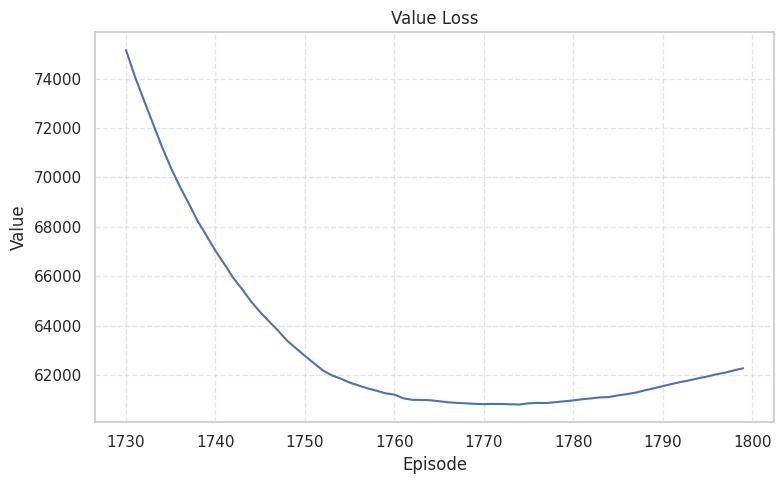

In [210]:
#FOCUS ON THE LAST VALUES
window_size = 500
moving_avg = moving_average(Value_loss, window_size)
num_values = 70  # Number of values to plot

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(Value_loss) - num_values, len(Value_loss)), moving_avg[-num_values:], label='Value Loss')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Value Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

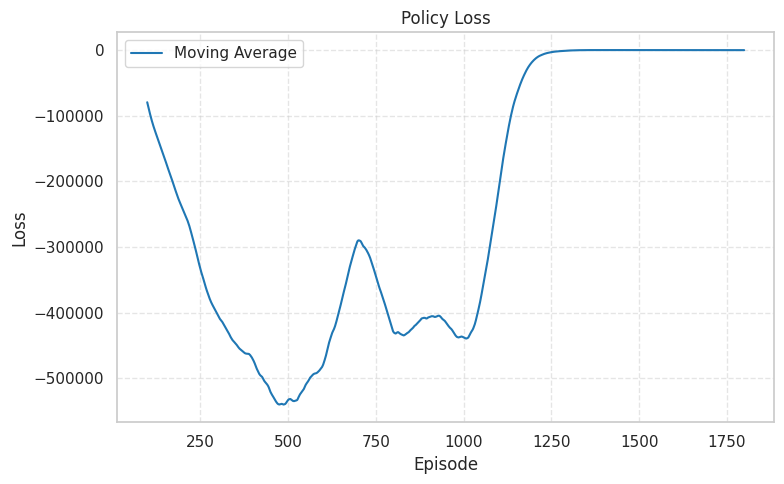

In [185]:
#Policy_loss = [int(tensor.item()) for tensor in Policy_loss]

window_size = 100
data = Policy_loss
moving_avg = moving_average(data, window_size)



plt.figure(figsize=(8, 5))  # Adjust figure size as needed
#plt.plot(data, marker='o', linestyle='-', color='b', label='Original Data')
plt.plot(np.arange(window_size - 1, len(data)), moving_avg, linestyle='-', color='tab:blue', label='Moving Average')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Policy Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

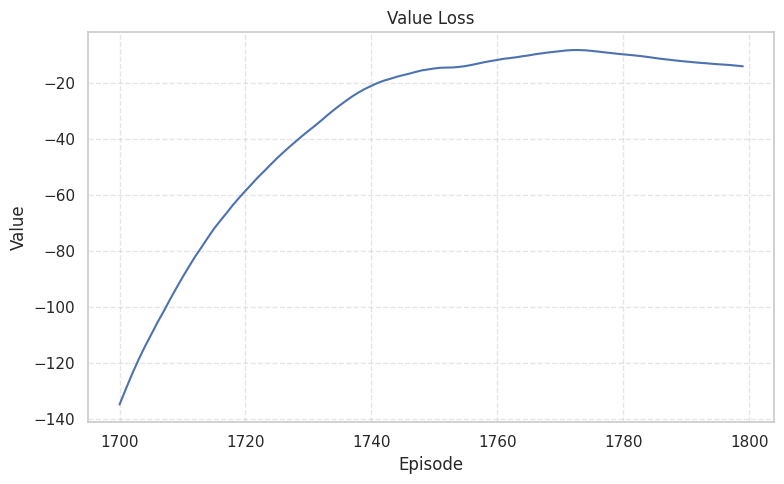

In [212]:
#FOCUS ON THE LAST VALUES
window_size = 500
moving_avg = moving_average(Policy_loss, window_size)
num_values = 100  # Number of values to plot

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(Policy_loss) - num_values, len(Policy_loss)), moving_avg[-num_values:], label='Value Loss')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Value Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

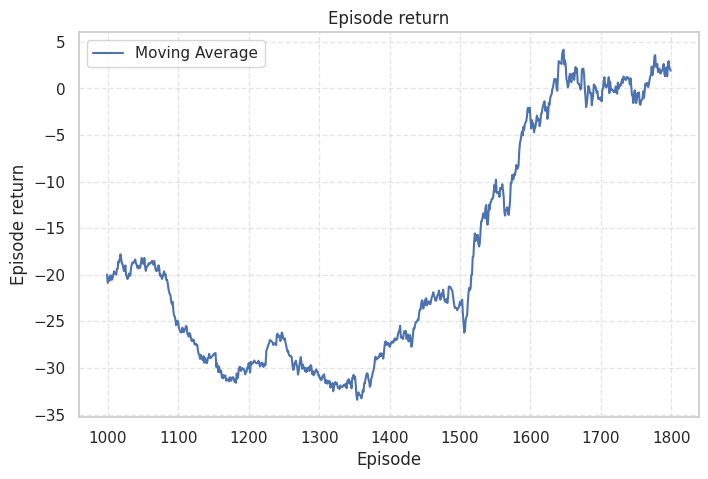

In [213]:
#Episode rewards


window_size = 1000
data = ep_relative_training_reward
moving_avg = moving_average(data, window_size)

plt.figure(figsize=(8, 5))  # Adjust figure size as needed
plt.plot(np.arange(window_size - 1, len(data)), moving_avg, label='Moving Average')
plt.xlabel('Episode')
plt.ylabel('Episode return')
plt.title('Episode return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


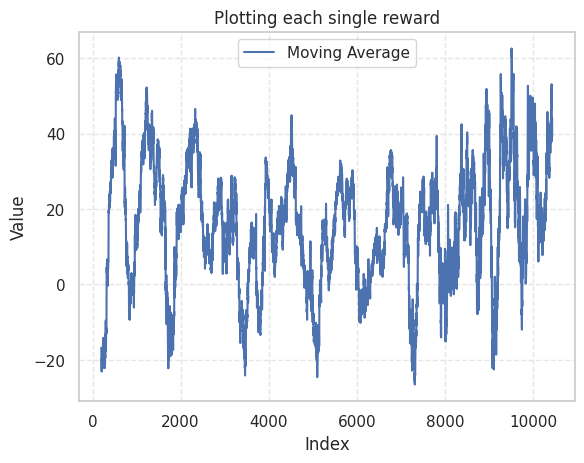

In [214]:
#Plotting each single reward
window_size  = 200
moving_avg = np.convolve(Training_reward, np.ones(window_size)/window_size, mode='valid')

# Plot the moving average
plt.plot(np.arange(window_size-1, len(Training_reward)), moving_avg, label='Moving Average')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plotting each single reward')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



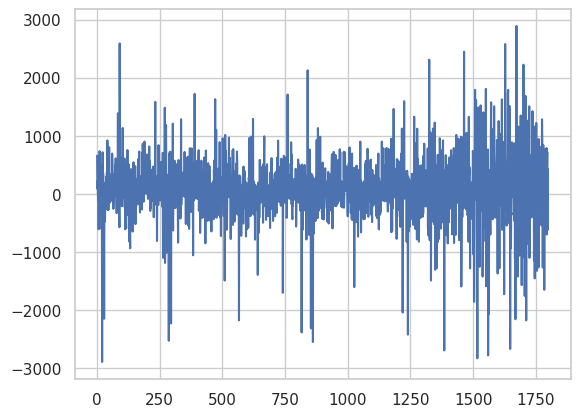

In [189]:
plt.plot(ep_reward, label='Reward')

In [190]:
np.median(Training_reward)

11.850128089878126

In [191]:
np.std(Training_reward)

251.44067501311739

<Axes: ylabel='Density'>

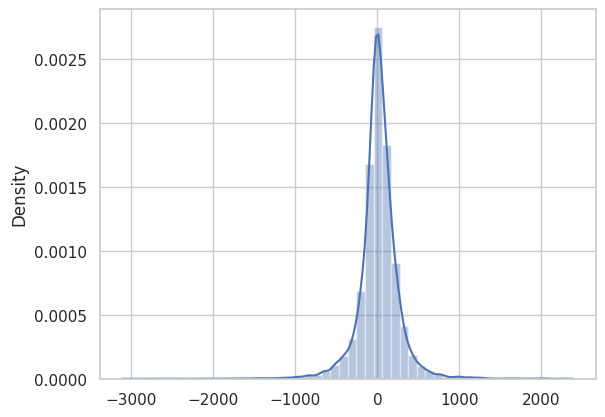

In [192]:
sns.distplot(Training_reward)

# Testing the DDPG Agent


In [193]:
import warnings
warnings.filterwarnings("ignore", message="np.find_common_type is deprecated", category=DeprecationWarning)

In [194]:
def baseline_plot(baseline_df, portfolio_return ):

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

  baseline_df['Value'][0]
  percentage_return_portfolio = (portfolio_return - portfolio_return[0]) / portfolio_return[0] * 100
  percentage_return_baseline = (baseline_df['Value'] - baseline_df['Value'][0]) / baseline_df['Value'][0] * 100

  plt.plot(percentage_return_portfolio, label='Portfolio')
  plt.plot(percentage_return_baseline, label='Baseline')

  # Add title and labels
  plt.title('Percentage Return of Portfolio')
  plt.xlabel('Date')
  plt.ylabel('Percentage Return')

  # Show legend
  plt.legend()

  # Show grid
  plt.grid(True)

  # Show plot
  plt.show()





In [216]:
def test_plots(baseline_df, portfolio_return, SP_return ):

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
  #first plot
  baseline_df['Value'][0]
  percentage_return_portfolio = (portfolio_return - portfolio_return[0]) / portfolio_return[0] * 100
  percentage_return_baseline = (baseline_df['Value'] - baseline_df['Value'][0]) / baseline_df['Value'][0] * 100

  axs[0].plot(percentage_return_portfolio, label='Portfolio')
  axs[0].plot(percentage_return_baseline, label='Baseline')

  # Add title and labels
  axs[0].set_title('Percentage Return of Portfolio vs Baseline')
  axs[0].set_xlabel('Date')
  axs[0].set_ylabel('Percentage Return')
  axs[0].legend()
  axs[0].grid(True)

  #second plot
  percentage_return_portfolio = (portfolio_return - portfolio_return[0]) / portfolio_return[0] * 100
  SP_return = np.array(SP_return, dtype=np.float64)
  percentage_return_SP500 = (SP_return - SP_return[0]) / SP_return[0] * 100

  axs[1].plot(percentage_return_portfolio, label='Portfolio')
  axs[1].plot(percentage_return_SP500, label='SP500')
  axs[1].set_title('Percentage Return of Portfolio vs. SP500')
  axs[1].set_xlabel('Date')
  axs[1].set_ylabel('Percentage Return')
  axs[1].legend()
  axs[1].grid(True)

  # Adjust layout to prevent overlap
  plt.tight_layout()


  # Show plot
  plt.show()

def net_return_calculator(portfolio_return, SP_return): #calculate the difference between the portfolio return and the SP500 retun
    percentage_return_portfolio = (portfolio_return[-1] - portfolio_return[0]) / portfolio_return[0] * 100
    SP_return = np.array(SP_return, dtype=np.float64)
    percentage_return_SP500 = (SP_return[-1] - SP_return[0]) / SP_return[0] * 100

    net_return = percentage_return_portfolio - percentage_return_SP500

    return net_return

def return_histo(data):

  sns.set(style="whitegrid")

  # Create histogram
  sns.histplot(data, bins = 30 , kde=False, color='skyblue', edgecolor='black')
  mu, std = norm.fit(data)

# Plot fitted normal distribution
  plt.text(0.75, 0.95, f'Mean: {mu:.2f}\nStd: {std:.2f}', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))


  # Customize labels and title
  plt.xlabel('Perid Percentage Return', fontsize=14)
  plt.ylabel('Frequency', fontsize=14)
  #plt.title('Return Distribution', fontsize=16)
  plt.legend()



  # Show plot
  plt.show()

In [217]:
import os
actor_weights = os.path.join('/content/drive/MyDrive/TESI/02_parameters', 'ddpg_actor_weights') #Critic_TrainingEpisode_NumEpisodes_Tau_Gamma
critic_weights =os.path.join('/content/drive/MyDrive/TESI/02_parameters', 'ddpg_critic_weights')

test_cycle = 180

test_env = trade_env(test, worth, test_cycle, rho)

test_iteration=100
reward_list = []
net_return_list = [] #lista con differenza tra ritorni portfolio e ritoni SP
net_return_portfolio_list = [] #lista con ritorni del portfolio
net_Baseline_return_list = []
for i in range(test_iteration):
    state, SPX_state = test_env.reset(worth)
    start_date = test_env.date
    portfolio_return = []
    Baseline_return = []
    Date = []
    for t in count():
        action = agent.select_action(state)
        next_state, reward, baseline_reward, utility, done, portfolio_worth, baseline_worth = test_env.step(action)
        portfolio_return.append(portfolio_worth)
        ep_r += reward
        #print(f"PORTFOLIO VALUE: {portfolio_worth} at iteration {t}")
        reward_list += [reward]
        #print(test_env.date)
        Baseline_return.append(baseline_worth)
        Date.append(test_env.date)
        #env.render()
        if done:
            net_return = net_return_calculator(portfolio_return, Baseline_return)#differenza tra ritorno finale del portfolio e ritorno finale SP500
            net_return_list.append(net_return)
            net_return_portfolio = (portfolio_return[-1] - portfolio_return[0])/portfolio_return[0] * 100
            net_return_portfolio_list.append(net_return_portfolio)
            net_Baseline_return = (Baseline_return[-1] - Baseline_return[0])/Baseline_return[0] * 100
            net_Baseline_return_list.append(net_Baseline_return)
            print(f"reward:{reward}, net return: {net_return}")
            print("Episode \t{}, the episode reward is \t{:0.2f}".format(i, ep_r))
            end_date = test_env.date
            ep_r = 0
            baseline_df =  baseline_portfolio(test_env.env, start_date, 20000, end_date)
            if t%1 == 0:
              test_plots(baseline_df, portfolio_return, Baseline_return)

            #env.render()

            break
        state = next_state

Output hidden; open in https://colab.research.google.com to view.

In [218]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def test_plots(baseline_df, portfolio_return, SP_return, dates):

    # Convert date strings to datetime objects
    dates = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates]

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Plotting the first subplot
    axs[0].plot_date(dates, portfolio_return, '-', label='Portfolio')
    axs[0].plot_date(dates, baseline_df['Value'], '-', label='Baseline')

    # Add title and labels
    axs[0].set_title('Percentage Return of Portfolio vs Baseline')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Percentage Return')
    axs[0].legend()
    axs[0].grid(True)

    # Plotting the second subplot
    axs[1].plot_date(dates, portfolio_return, '-', label='Portfolio')
    axs[1].plot_date(dates, SP_return, '-', label='SP500')
    axs[1].set_title('Percentage Return of Portfolio vs. SP500')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Percentage Return')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show plot
    plt.show()

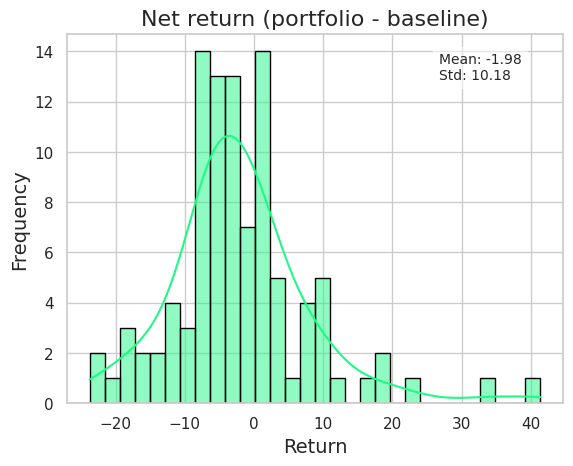

In [219]:
from scipy.stats import norm
sns.set(style="whitegrid")




# Create histogram
sns.histplot(net_return_list, bins = 30 , kde=True, color='#20f986', edgecolor='black')
mu, std = norm.fit(net_return_list)

# Plot fitted normal distribution
plt.text(0.75, 0.95, f'Mean: {mu:.2f}\nStd: {std:.2f}', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))



# Customize labels and title
plt.xlabel('Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Net return (portfolio - baseline)', fontsize=16)




# Show plot
plt.show()

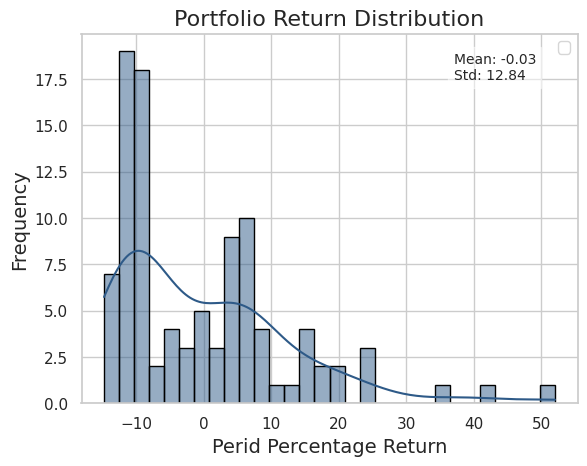

In [220]:
sns.set(style="whitegrid")
data = net_return_portfolio_list
# Create histogram
sns.histplot(data, bins = 30 , kde=True, color='#2e5a88', edgecolor='black')
mu, std = norm.fit(data)

# Plot fitted normal distribution
plt.text(0.75, 0.95, f'Mean: {mu:.2f}\nStd: {std:.2f}', transform=plt.gca().transAxes,
        fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))


# Customize labels and title
plt.xlabel('Perid Percentage Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Portfolio Return Distribution', fontsize=16)
plt.legend()



# Show plot
plt.show()

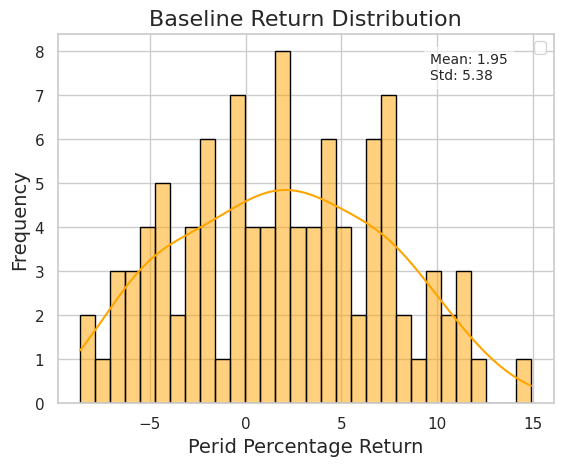

In [221]:
sns.set(style="whitegrid")
data = net_Baseline_return_list
# Create histogram
sns.histplot(data, bins = 30 , kde=True, color='orange', edgecolor='black')
mu, std = norm.fit(data)

# Plot fitted normal distribution
plt.text(0.75, 0.95, f'Mean: {mu:.2f}\nStd: {std:.2f}', transform=plt.gca().transAxes,
        fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))


# Customize labels and title
plt.xlabel('Perid Percentage Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Baseline Return Distribution', fontsize=16)
plt.legend()



# Show plot
plt.show()

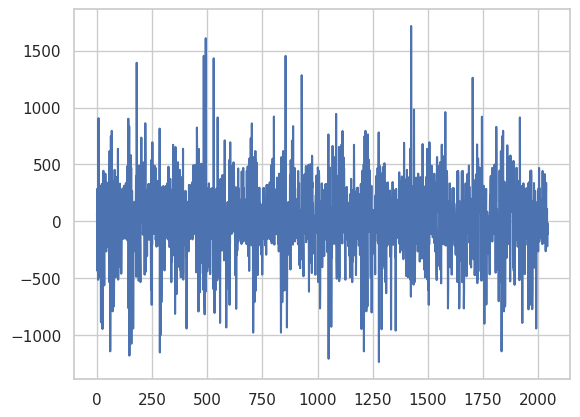

In [201]:
plt.plot(reward_list)


In [202]:
np.median(reward_list)


14.003692626953125

In [203]:
np.mean(reward_list)


5.650808186053055

In [204]:
np.std(reward_list)

335.1324755386294

<Axes: ylabel='Density'>

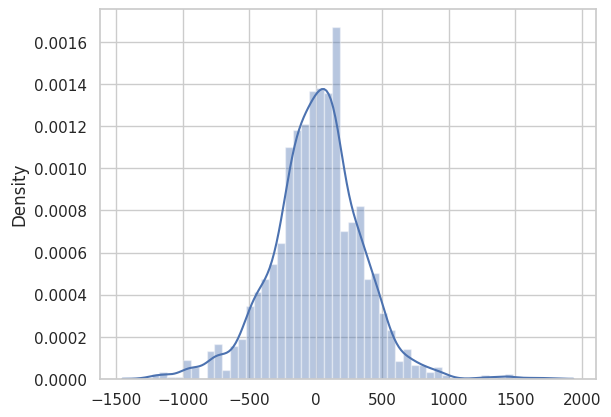

In [205]:
sns.distplot(reward_list)

PLOTS

In [206]:
percentage_return_UNH = (stock_d['UNH']['adj close'] - stock_d['UNH']['adj close'].iloc[0]) / stock_d['UNH']['adj close'].iloc[0] * 100
percentage_return_UNH.index = stock_d['UNH']['Date']
percentage_return_SP500 = (stock_d['^GSPC']['adj close'] - stock_d['^GSPC']['adj close'].iloc[0]) / stock_d['^GSPC']['adj close'].iloc[0] * 100
percentage_return_SP500.index = stock_d['UNH']['Date']
percentage_return_PG = (stock_d['PG']['adj close'] - stock_d['PG']['adj close'].iloc[0]) / stock_d['PG']['adj close'].iloc[0] * 100
percentage_return_PG.index = stock_d['UNH']['Date']
percentage_return_AAPL = (stock_d['AAPL']['adj close'] - stock_d['AAPL']['adj close'].iloc[0]) / stock_d['AAPL']['adj close'].iloc[0] * 100
percentage_return_AAPL.index = stock_d['UNH']['Date']
percentage_return_XOM = (stock_d['XOM']['adj close'] - stock_d['XOM']['adj close'].iloc[0]) / stock_d['XOM']['adj close'].iloc[0] * 100
percentage_return_XOM.index = stock_d['UNH']['Date']
percentage_return_JPM = (stock_d['JPM']['adj close'] - stock_d['JPM']['adj close'].iloc[0]) / stock_d['JPM']['adj close'].iloc[0] * 100
percentage_return_JPM.index = stock_d['UNH']['Date']

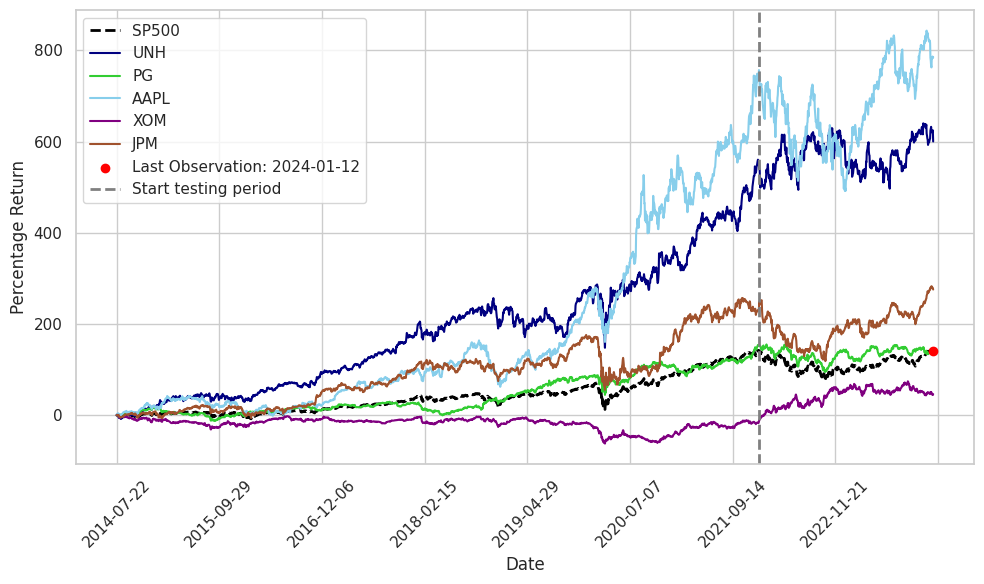

In [207]:
import matplotlib.pyplot as plt

percentage_return_UNH = (stock_d['UNH']['adj close'] - stock_d['UNH']['adj close'].iloc[0]) / stock_d['UNH']['adj close'].iloc[0] * 100
percentage_return_UNH.index = stock_d['UNH']['Date']
percentage_return_SP500 = (stock_d['^GSPC']['adj close'] - stock_d['^GSPC']['adj close'].iloc[0]) / stock_d['^GSPC']['adj close'].iloc[0] * 100
percentage_return_SP500.index = stock_d['UNH']['Date']
percentage_return_PG = (stock_d['PG']['adj close'] - stock_d['PG']['adj close'].iloc[0]) / stock_d['PG']['adj close'].iloc[0] * 100
percentage_return_PG.index = stock_d['UNH']['Date']
percentage_return_AAPL = (stock_d['AAPL']['adj close'] - stock_d['AAPL']['adj close'].iloc[0]) / stock_d['AAPL']['adj close'].iloc[0] * 100
percentage_return_AAPL.index = stock_d['UNH']['Date']
percentage_return_XOM = (stock_d['XOM']['adj close'] - stock_d['XOM']['adj close'].iloc[0]) / stock_d['XOM']['adj close'].iloc[0] * 100
percentage_return_XOM.index = stock_d['UNH']['Date']
percentage_return_JPM = (stock_d['JPM']['adj close'] - stock_d['JPM']['adj close'].iloc[0]) / stock_d['JPM']['adj close'].iloc[0] * 100
percentage_return_JPM.index = stock_d['UNH']['Date']

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
ax.plot(percentage_return_UNH.index, percentage_return_SP500.values, color='black', linewidth=2, linestyle='--', label='SP500')
ax.plot(percentage_return_UNH.index, percentage_return_UNH.values, color='navy', linewidth=1.5, label='UNH')
ax.plot(percentage_return_UNH.index, percentage_return_PG.values, color='limegreen', linewidth=1.5, label='PG')
ax.plot(percentage_return_UNH.index, percentage_return_AAPL.values, color='skyblue', linewidth=1.5, label='AAPL')
ax.plot(percentage_return_UNH.index, percentage_return_XOM.values, color='Purple', linewidth=1.5, label='XOM')
ax.plot(percentage_return_UNH.index, percentage_return_JPM.values, color='Sienna', linewidth=1.5, label='JPM')

# Set x-axis label
ax.set_xlabel('Date')

# Get the last observation date and value
last_observation_date = percentage_return_SP500.index[-1]
last_observation_value = percentage_return_SP500.values[-1]

# Add the last observation to the plot
ax.scatter(last_observation_date, last_observation_value, color='red', label=f'Last Observation: {last_observation_date}', zorder=5)

# Add a vertical line at the specified date
ax.axvline(x='2022-01-04', color='gray', linestyle='--', linewidth=2, label='Start testing period')

# Set y-axis label
ax.set_ylabel('Percentage Return')

# Add gridlines
ax.grid(True)

# Set x-axis ticks to show only the year
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.legend()
plt.show()

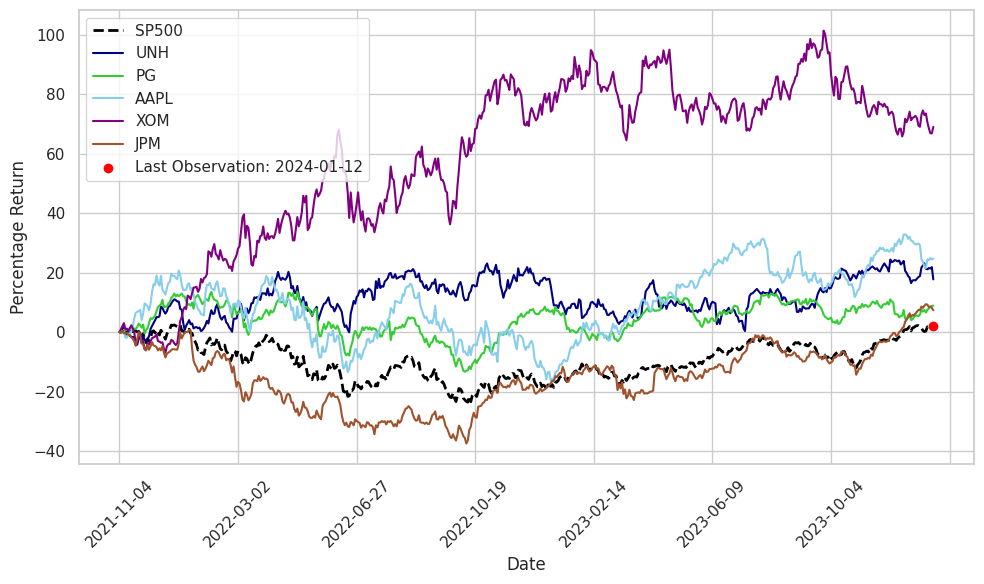

In [208]:
import matplotlib.pyplot as plt

percentage_return_UNH = (stock_d['UNH']['adj close'][-550:] - stock_d['UNH']['adj close'][-550:].iloc[0]) / stock_d['UNH']['adj close'][-550:].iloc[0] * 100
percentage_return_UNH.index = stock_d['UNH']['Date'][-550:]
percentage_return_SP500 = (stock_d['^GSPC']['adj close'][-550:] - stock_d['^GSPC']['adj close'][-550:].iloc[0]) / stock_d['^GSPC']['adj close'][-550:].iloc[0] * 100
percentage_return_SP500.index = stock_d['UNH']['Date'][-550:]
percentage_return_PG = (stock_d['PG']['adj close'][-550:] - stock_d['PG']['adj close'][-550:].iloc[0]) / stock_d['PG']['adj close'][-550:].iloc[0] * 100
percentage_return_PG.index = stock_d['UNH']['Date'][-550:]
percentage_return_AAPL = (stock_d['AAPL']['adj close'][-550:] - stock_d['AAPL']['adj close'][-550:].iloc[0]) / stock_d['AAPL']['adj close'][-550:].iloc[0] * 100
percentage_return_AAPL.index = stock_d['UNH']['Date'][-550:]
percentage_return_XOM = (stock_d['XOM']['adj close'][-550:] - stock_d['XOM']['adj close'][-550:].iloc[0]) / stock_d['XOM']['adj close'][-550:].iloc[0] * 100
percentage_return_XOM.index = stock_d['UNH']['Date'][-550:]
percentage_return_JPM = (stock_d['JPM']['adj close'][-550:] - stock_d['JPM']['adj close'][-550:].iloc[0]) / stock_d['JPM']['adj close'][-550:].iloc[0] * 100
percentage_return_JPM.index = stock_d['UNH']['Date'][-550:]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
ax.plot(percentage_return_UNH.index, percentage_return_SP500.values, color='black', linewidth=2, linestyle='--', label='SP500')
ax.plot(percentage_return_UNH.index, percentage_return_UNH.values, color='navy', linewidth=1.5, label='UNH')
ax.plot(percentage_return_UNH.index, percentage_return_PG.values, color='limegreen', linewidth=1.5, label='PG')
ax.plot(percentage_return_UNH.index, percentage_return_AAPL.values, color='skyblue', linewidth=1.5, label='AAPL')
ax.plot(percentage_return_UNH.index, percentage_return_XOM.values, color='Purple', linewidth=1.5, label='XOM')
ax.plot(percentage_return_UNH.index, percentage_return_JPM.values, color='Sienna', linewidth=1.5, label='JPM')

# Set x-axis label
ax.set_xlabel('Date')

# Get the last observation date and value
last_observation_date = percentage_return_SP500.index[-1]
last_observation_value = percentage_return_SP500.values[-1]

# Add the last observation to the plot
ax.scatter(last_observation_date, last_observation_value, color='red', label=f'Last Observation: {last_observation_date}', zorder=5)

# Add a vertical line at the specified date
#ax.axvline(x='2022-01-04', color='gray', linestyle='--', linewidth=2, label='Start testing period')

# Set y-axis label
ax.set_ylabel('Percentage Return')

# Add gridlines
ax.grid(True)

# Set x-axis ticks to show only the year
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.legend()
plt.show()

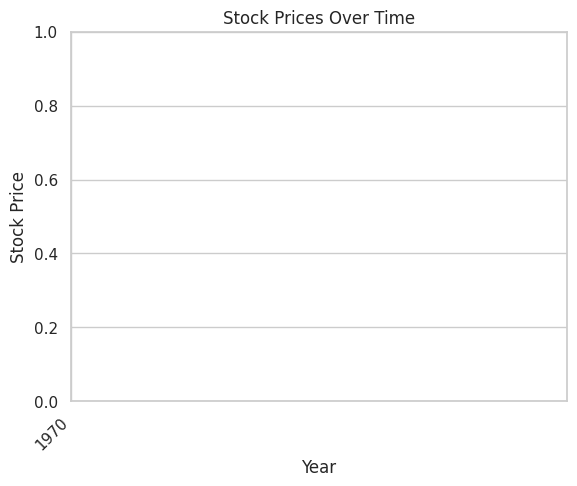

In [209]:
from matplotlib.dates import YearLocator, DateFormatter
percentage_return_UNH = (stock_d['UNH']['adj close'] - stock_d['UNH']['adj close'].iloc[0]) / stock_d['UNH']['adj close'].iloc[0] * 100
percentage_return_SP500 = (stock_d['^GSPC']['adj close'] - stock_d['^GSPC']['adj close'].iloc[0]) / stock_d['^GSPC']['adj close'].iloc[0] * 100
percentage_return_PG = (stock_d['PG']['adj close'] - stock_d['PG']['adj close'].iloc[0]) / stock_d['PG']['adj close'].iloc[0] * 100
percentage_return_AAPL = (stock_d['AAPL']['adj close'] - stock_d['AAPL']['adj close'].iloc[0]) / stock_d['AAPL']['adj close'].iloc[0] * 100
percentage_return_XOM = (stock_d['XOM']['adj close'] - stock_d['XOM']['adj close'].iloc[0]) / stock_d['XOM']['adj close'].iloc[0] * 100

start_date = pd.to_datetime('2014-07-22')  # Example start date
end_date = pd.to_datetime('2024-01-12')    # Example end date
dates = pd.date_range(start=start_date, end=end_date, freq='D')

prices_series = pd.Series(percentage_return_UNH, index=pd.date_range(start_date, end_date))
'''
percentage_return_UNH.plot(label='Stock UNH')
percentage_return_SP500.plot(label='Stock SP500')
percentage_return_PG.plot(label='PG')
percentage_return_AAPL.plot(label='AAPL')
percentage_return_XOM.plot(label='XOM')'''

plt.xticks(rotation=45, ha='right')  # Rotate and right-align x-axis labels for better readability
plt.gca().xaxis.set_major_locator(YearLocator())  # Set major ticks to occur every year
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Format major ticks to show year only

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Stock Price")
plt.title("Stock Prices Over Time")

plt.grid(True)  # Add grid lines for better readability
plt.show()